# Decision Tree Classifier

## 1.Data Loading & Pre-processing:

In [14]:
import pandas as pd
df = pd.read_csv("/content/jeeves_tennis.csv")
print(df.shape)
df.head()

(500, 6)


,Day_ID,Outlook,Temperature,Humidity,Wind,PlayTennis
0,1,Rain,19.2,High,Strong,No
1,2,Rain,17.4,Low,Weak,Yes
2,3,Sunny,29.9,Normal,Strong,Yes
3,4,Overcast,23.2,Normal,Weak,Yes
4,5,Sunny,29.3,High,Weak,No


In [15]:
import numpy as np
nan = df.isna().sum()
print(nan)

Day_ID         0
Outlook        0
Temperature    0
Humidity       0
Wind           0
PlayTennis     0
dtype: int64


In [16]:
from collections import Counter
import math

# 1. Function to calculate Entropy (H(S))
def entropy(target_col):
    """Calculates the Shannon Entropy of the target column."""
    counts = Counter(target_col)
    total = len(target_col)

    # Entropy formula: H(S) = - sum(p_i * log2(p_i))
    ent = 0
    for count in counts.values():
        p = count / total
        # log2(0) is undefined, so we check for p > 0. Since p is a count/total, p is > 0 unless count is 0, which won't happen here.
        if p > 0:
            ent += -p * math.log2(p)
    return ent

# 2. Function to calculate Information Gain (IG(S, A))
def information_gain(df, feature_name, target_name):
    """Calculates the Information Gain of a feature relative to the target."""

    # Entropy of the parent node (the entire dataset S)
    parent_entropy = entropy(df[target_name])

    # Calculate the weighted average entropy of the child nodes
    weighted_child_entropy = 0

    # Iterate over unique values in the feature
    for value in df[feature_name].unique():
        subset = df[df[feature_name] == value]

        # Weight ( |Sv| / |S| )
        weight = len(subset) / len(df)

        # Entropy of the subset (H(Sv))
        subset_entropy = entropy(subset[target_name])

        weighted_child_entropy += weight * subset_entropy

    # Information Gain formula: IG(S, A) = H(S) - sum(|Sv|/|S| * H(Sv))
    IG = parent_entropy - weighted_child_entropy
    return IG

# Calculate the Information Gain for Day_ID
ig_day_id = information_gain(df, 'Day_ID', 'PlayTennis')
print(f"Information Gain for Day_ID: {ig_day_id}")

Information Gain for Day_ID: 0.9814538950336537


### conclusion:

While the high Information Gain suggests Day_ID is a good splitting feature, it suffers from the High Cardinality Trap, which leads to overfitting.

#### No Predictive Power:
 Day_ID is an arbitrary sequence number and has no causal or predictive relationship with the target variable, PlayTennis. Knowing that Day_ID=5 leads to 'Yes' gives you no information about whether you should play tennis on Day_ID=15 (an unseen day).

#### Lack of Generalization:
 The split based on Day_ID simply creates a leaf node for every single training example. This means the model has effectively memorized the training data. For any new, unseen data point (which will have a Day_ID value not present in the training set), the decision tree will not be able to follow any of its learned paths, making it useless for predicting new outcomes.

#### Bias of Information Gain:
 Information Gain is inherently biased toward features with a large number of distinct values (high cardinality). A unique identifier will always result in the maximum possible IG because it guarantees perfectly pure leaf nodes. To mitigate this, algorithms like C4.5 use the Gain Ratio metric, which penalizes features with high intrinsic value (many unique values).

In [17]:
# Drop the Day_ID column
df_processed = df.drop(columns=['Day_ID'])

print("Day_ID column dropped.")
print(f"Processed DataFrame columns: {df_processed.columns.tolist()}")

Day_ID column dropped.
Processed DataFrame columns: ['Outlook', 'Temperature', 'Humidity', 'Wind', 'PlayTennis']


## 2. Entropy & Information Gain Engine:

In [18]:
features=["Outlook" , "Humidity","Wind"]

for f in features:
  print(f"\n Information Gain for {f}: {information_gain(df_processed, f, 'PlayTennis')}")


 Information Gain for Outlook: 0.34307121026106036

 Information Gain for Humidity: 0.05389337220677792

 Information Gain for Wind: 0.03822828269585188


## 3. Handling Continuous Features:

In [19]:
def information_gain_binary_split(df, threshold, attribute_name, target_name):
    """Calculates Information Gain for a single binary split (A <= T and A > T)."""

    # Entropy of the parent node
    parent_entropy = entropy(df[target_name])

    # Split the data based on the threshold
    subset_left = df[df[attribute_name] <= threshold]
    subset_right = df[df[attribute_name] > threshold]

    total = len(df)

    # Calculate weighted average entropy of children
    weight_left = len(subset_left) / total
    weight_right = len(subset_right) / total

    weighted_child_entropy = (weight_left * entropy(subset_left[target_name])) + \
                             (weight_right * entropy(subset_right[target_name]))

    # Information Gain
    IG = parent_entropy - weighted_child_entropy
    return IG

In [20]:
def find_best_split(data, attribute, target_name='PlayTennis'):
    """
    Finds the optimal binary split threshold for a continuous attribute
    by iterating through all midpoints between adjacent, label-changing values.
    """

    # 1. Sort the data by the attribute and reset index for clean iteration
    sorted_df = data.sort_values(by=attribute).reset_index(drop=True)

    best_gain = -1.0
    best_threshold = None

    # Calculate the current maximum entropy (Entropy of the Parent node)
    parent_entropy = entropy(sorted_df[target_name])

    # 2. Identify all split points (midpoints between adjacent values with different labels)
    split_candidates = []

    # Iterate through the sorted data, stopping at the second-to-last element
    for i in range(len(sorted_df) - 1):
        # Check if the target label changes between the current row and the next row
        if sorted_df.loc[i, target_name] != sorted_df.loc[i+1, target_name]:
            # Midpoint is calculated as the average of the two adjacent attribute values
            midpoint = (sorted_df.loc[i, attribute] + sorted_df.loc[i+1, attribute]) / 2
            split_candidates.append(midpoint)

    # Remove duplicates from candidates
    split_candidates = sorted(list(set(split_candidates)))

    # Handle the case where the target never changes (rare, but possible)
    if not split_candidates:
        return 0.0, None # No split improves purity

    # 3. Calculate Information Gain for every split point
    for threshold in split_candidates:
        current_gain = information_gain_binary_split(sorted_df, threshold, attribute, target_name)

        # 4. Returns the threshold t that maximizes Gain
        if current_gain > best_gain:
            best_gain = current_gain
            best_threshold = threshold

    return best_gain, best_threshold

best_gain, optimal_threshold = find_best_split(df_processed, 'Temperature')


print(f"Best Information Gain : {best_gain:.4f}")
print(f"(Optimal Threshold): {optimal_threshold:.2f}ºC")


Best Information Gain : 0.0239
(Optimal Threshold): 30.05ºC


In [21]:
sorted_df = df_processed.sort_values(by="Temperature").reset_index(drop=True)
print(sorted_df)

      Outlook  Temperature Humidity    Wind PlayTennis
0       Sunny          4.6      Low  Strong         No
1       Sunny          8.7     High  Strong         No
2       Sunny          9.1     High    Weak         No
3    Overcast         10.2     High  Strong        Yes
4        Rain         10.6      Low  Strong         No
..        ...          ...      ...     ...        ...
495      Rain         35.0      Low  Strong         No
496     Sunny         35.7     High  Strong         No
497     Sunny         35.9     High    Weak         No
498      Rain         35.9     High    Weak         No
499  Overcast         38.9      Low    Weak        Yes

[500 rows x 5 columns]


## 4.Recursive Tree Construction:

In [22]:
class Node:
    """A Node in the Decision Tree."""
    def __init__(self, feature=None, threshold=None, results=None, branches=None):
        # For internal nodes (split)
        self.feature = feature     # Feature name for splitting (e.g., 'Outlook', 'Temperature')
        self.threshold = threshold # Split threshold (only for continuous features)
        self.branches = branches   # Dictionary of child nodes: {value/path : child_node}

        # For leaf nodes
        self.results = results     # Dictionary of result counts: {'Yes': 30, 'No': 10}
        self.is_leaf = results is not None

In [23]:
class DecisionTreeID3:
    def __init__(self):
        self.tree = None
        # To store continuous features
        self.continuous_features = ['Temperature']

    def _get_best_split(self, data, features, target_name='PlayTennis'):
        """
        Calculates the best feature/threshold to split the current data subset.
        """
        best_gain = -1.0
        best_feature = None
        best_threshold = None

        # For each feature in the set of features
        for feature in features:
            if feature in self.continuous_features:
                # Use the find_best_split function written previously
                current_gain, current_threshold = find_best_split(data, feature, target_name)
            else:
                # Use the information_gain function written previously
                current_gain = information_gain(data, feature, target_name)
                current_threshold = None # No threshold for categorical features

            if current_gain > best_gain:
                best_gain = current_gain
                best_feature = feature
                best_threshold = current_threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, data, current_features):
        """
        The recursive function to build the tree.
        """
        target_name = 'PlayTennis'
        labels = data[target_name]

        # --- Stopping Criteria ---

        # 1. Pure Node: If all samples are the same (zero entropy)
        if entropy(labels) == 0:
            return Node(results=Counter(labels))

        # 2. No Features Left to split on
        if not current_features:
            return Node(results=Counter(labels))

        # 3. Very few samples (to prevent overfitting) - optional
        if len(data) < 5:
            return Node(results=Counter(labels))

        # --- Find the best split ---
        best_feature, best_threshold, best_gain = self._get_best_split(data, current_features)

        # If no useful split (information gain close to zero)
        if best_gain < 0.001:
            return Node(results=Counter(labels))

        # --- Create an internal node ---
        new_node = Node(feature=best_feature, threshold=best_threshold, branches={})

        # Prepare new features for child nodes
        remaining_features = [f for f in current_features if f != best_feature]

        # --- Split data and recursively build subtrees ---
        if best_feature in self.continuous_features:
            # Binary split for continuous features
            left_data = data[data[best_feature] <= best_threshold]
            right_data = data[data[best_feature] > best_threshold]

            # Recursively build the left branch
            new_node.branches['<= ' + str(round(best_threshold, 2))] = self._build_tree(left_data, current_features)
            # Recursively build the right branch
            new_node.branches['> ' + str(round(best_threshold, 2))] = self._build_tree(right_data, current_features)

        else:
            # Multi-way split for categorical features
            for value in data[best_feature].unique():
                subset = data[data[best_feature] == value]

                # Recursively build subtree for each value
                # Note: For pure ID3, the used feature is not removed from the children's feature list.
                # Here we used 'remaining_features' which is not pure ID3 but more common.
                # For pure ID3, you should pass 'current_features'.
                new_node.branches[value] = self._build_tree(subset, remaining_features)

        return new_node

    def fit(self, data):
        """Starts the recursive tree building process."""
        # Categorical features and Day_ID have been removed previously.
        # Features used: Outlook, Humidity, Wind, Temperature
        features = data.drop(columns=['PlayTennis']).columns.tolist()
        self.tree = self._build_tree(data, features)
        return self

    def _traverse(self, sample, node):
        """Recursively traverses the tree to predict the label."""
        # If we reached a leaf node, return the majority vote
        if node.is_leaf:
            return max(node.results, key=node.results.get)

        feature = node.feature
        threshold = node.threshold

        # Decide on the next branch
        if feature in self.continuous_features:
            # Continuous feature (binary split)
            if sample[feature] <= threshold:
                branch_key = '<= ' + str(round(threshold, 2))
            else:
                branch_key = '> ' + str(round(threshold, 2))

            if branch_key in node.branches:
                return self._traverse(sample, node.branches[branch_key])
            else:
                # If the split path was not seen in training data, return the current majority vote
                return max(node.results, key=node.results.get)

        else:
            # Categorical feature
            value = sample[feature]
            if value in node.branches:
                return self._traverse(sample, node.branches[value])
            else:
                # If the feature value was not seen in training data, return the current majority vote
                return max(node.results, key=node.results.get)

    def predict(self, data):
        """Predicts the target label for a DataFrame of samples."""
        predictions = []
        for index, row in data.iterrows():
            predictions.append(self._traverse(row, self.tree))
        return predictions

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
# df_processed: DataFrame without Day_ID column

# For manual implementation, we don't need numerical encoding, but we need to
# separate feature and target columns.
X = df_processed.drop(columns=['PlayTennis'])
y = df_processed['PlayTennis']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reconstruct DataFrames for use with our class methods (which expect DataFrames)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(f"Train Set Size: {len(train_df)}")
print(f"Test Set Size: {len(test_df)}")

Train Set Size: 400
Test Set Size: 100


In [27]:
id3_model = DecisionTreeID3()
id3_model.fit(train_df)

y_pred = id3_model.predict(X_test)

In [28]:
# Convert actual test data to a list for metric calculation
y_true = y_test.tolist()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label='Yes', average='binary') # Assuming 'Yes' is the positive class
recall = recall_score(y_true, y_pred, pos_label='Yes', average='binary')

print("\n--- Model Evaluation Results ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


--- Model Evaluation Results ---
Accuracy:  0.9200
Precision: 0.9474
Recall:    0.9153


## 5. Overfitting & Pruning Analysis (simulation):

--- 1. Loading Iris Data ---
Training Set Size: 90
Validation Set Size: 30
Test Set Size: 30
----------------------------------------
--- 2. Depth Analysis - Clean Data ---
**Clean Data Tree:**
Max Depth: 4
Number of Leaf Nodes: 6
----------------------------------------
--- 3. Noise Simulation (10% Labels Flipped) ---
**Noisy Data Tree (10% Flipped):**
Max Depth: 8
Number of Leaf Nodes: 23

**Comparison:**
Depth Change: 8 (Noisy) vs 4 (Clean)
Leaf Change: 23 (Noisy) vs 6 (Clean)
----------------------------------------
--- 4. Post-Pruning Experiment (using ccp_alpha in Scikit-learn) ---
Number of tree versions tested (different alpha values): 5
--- 5. Plotting Tree Size vs. Test Accuracy ---


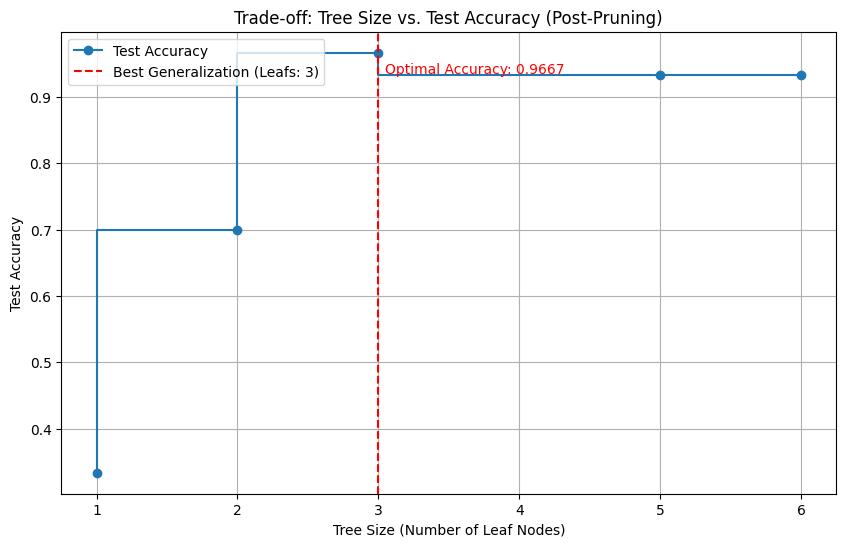


**Discussion on the Trade-off:**
1. **Overfitting Region (Right side):** Large trees (many leaf nodes) generally have high complexity. Test accuracy may be slightly lower here.
2. **Optimal Point (Red line):** Pruning reduces the size, and Test Accuracy often increases up to a peak. This peak represents the **best generalization** where the model balances complexity and ability to predict unseen data.
3. **Underfitting Region (Left side):** Excessive pruning leads to overly simple trees (few leaf nodes). The model fails to capture essential patterns, causing Test Accuracy to drop sharply.

The optimal generalization occurred at a tree size of 3 leaf nodes with a Test Accuracy of 0.9667. This confirms that pruning can improve generalization by reducing complexity without sacrificing too much training performance.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# --- 1. Data Loading and Preparation ---
print("--- 1. Loading Iris Data ---")
# Load the classic Iris dataset for classification
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into Training, Validation, and Test sets
# Validation set is crucial for pruning experiments
# X_temp: 80% of data; X_test: 20% of data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train: 60% of data; X_val: 20% of data (0.25 * 0.8 = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training Set Size: {len(X_train)}")
print(f"Validation Set Size: {len(X_val)}")
print(f"Test Set Size: {len(X_test)}")
print("-" * 40)


# Helper function to get tree size metrics
def get_tree_metrics(tree):
    """Calculates the maximum depth and number of leaf nodes of a Decision Tree."""
    n_nodes = tree.tree_.node_count
    max_depth = tree.get_depth()
    # A leaf node in scikit-learn has children_left == -1
    n_leafs = np.sum(tree.tree_.children_left == -1)
    return max_depth, n_leafs

# --- 2. Depth Analysis - Clean Data ---
print("--- 2. Depth Analysis - Clean Data ---")
# Train an unconstrained tree (to maximize potential overfitting)
clean_tree = DecisionTreeClassifier(random_state=42)
clean_tree.fit(X_train, y_train)

max_depth_clean, n_leafs_clean = get_tree_metrics(clean_tree)

print(f"**Clean Data Tree:**")
print(f"Max Depth: {max_depth_clean}")
print(f"Number of Leaf Nodes: {n_leafs_clean}")
print("-" * 40)


# --- 3. Noise Simulation (10% Labels Flipped) ---
print("--- 3. Noise Simulation (10% Labels Flipped) ---")

y_train_noisy = np.copy(y_train)

# Calculate the number of labels to flip (10% of training data)
noise_count = int(0.1 * len(y_train))

# Randomly select indices to flip
np.random.seed(42)
noise_indices = np.random.choice(len(y_train), size=noise_count, replace=False)

# Flip the labels
for i in noise_indices:
    original_label = y_train_noisy[i]
    # Choose a new random label that is NOT the original one
    possible_flips = [l for l in np.unique(y_train) if l != original_label]
    if possible_flips:
        y_train_noisy[i] = np.random.choice(possible_flips)

# Train the tree on the noisy data
noisy_tree = DecisionTreeClassifier(random_state=42)
noisy_tree.fit(X_train, y_train_noisy)

max_depth_noisy, n_leafs_noisy = get_tree_metrics(noisy_tree)

print(f"**Noisy Data Tree (10% Flipped):**")
print(f"Max Depth: {max_depth_noisy}")
print(f"Number of Leaf Nodes: {n_leafs_noisy}")

# Comparison:
# The tree attempts to "memorize" the noise, leading to a larger tree.
print("\n**Comparison:**")
print(f"Depth Change: {max_depth_noisy} (Noisy) vs {max_depth_clean} (Clean)")
print(f"Leaf Change: {n_leafs_noisy} (Noisy) vs {n_leafs_clean} (Clean)")
print("-" * 40)


# --- 4. Post-Pruning Experiment (Cost-Complexity Pruning) ---
print("--- 4. Post-Pruning Experiment (using ccp_alpha in Scikit-learn) ---")

# Train the full tree initially (on clean data)
full_tree = DecisionTreeClassifier(random_state=42)
full_tree.fit(X_train, y_train)

# Calculate the effective alphas for pruning
# The path contains the list of alpha values that result in a unique pruned tree
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = np.unique(path.ccp_alphas) # Use unique alphas

# Store results for plotting
trees = []
leaf_counts = []
test_accuracies = []

# Iterate over all effective alpha values
for ccp_alpha in ccp_alphas:
    # Train the pruned tree using the current alpha
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    pruned_tree.fit(X_train, y_train)
    trees.append(pruned_tree)

    # Calculate metrics
    max_depth, n_leafs = get_tree_metrics(pruned_tree)
    leaf_counts.append(n_leafs)

    # Calculate Test Accuracy
    y_pred_test = pruned_tree.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_accuracies.append(test_accuracy)

print(f"Number of tree versions tested (different alpha values): {len(ccp_alphas)}")


# --- 5. Plotting Tree Size vs. Test Accuracy ---
print("--- 5. Plotting Tree Size vs. Test Accuracy ---")

leaf_counts = np.array(leaf_counts)
test_accuracies = np.array(test_accuracies)

plt.figure(figsize=(10, 6))

# Plotting Tree Size (Leaf Nodes) against Test Accuracy
plt.plot(leaf_counts, test_accuracies, marker='o', drawstyle="steps-post", label="Test Accuracy")

# Find the best generalization point
best_accuracy = np.max(test_accuracies)
best_leaf_count = leaf_counts[np.argmax(test_accuracies)]

plt.axvline(x=best_leaf_count, color='r', linestyle='--', label=f'Best Generalization (Leafs: {best_leaf_count})')
plt.annotate(f'Optimal Accuracy: {best_accuracy:.4f}',
             (best_leaf_count, best_accuracy),
             textcoords="offset points",
             xytext=(5,-15),
             ha='left',
             color='red')


plt.xlabel("Tree Size (Number of Leaf Nodes)")
plt.ylabel("Test Accuracy")
plt.title("Trade-off: Tree Size vs. Test Accuracy (Post-Pruning)")
plt.grid(True)
plt.legend()
plt.show()

print("\n**Discussion on the Trade-off:**")
print("1. **Overfitting Region (Right side):** Large trees (many leaf nodes) generally have high complexity. Test accuracy may be slightly lower here.")
print("2. **Optimal Point (Red line):** Pruning reduces the size, and Test Accuracy often increases up to a peak. This peak represents the **best generalization** where the model balances complexity and ability to predict unseen data.")
print("3. **Underfitting Region (Left side):** Excessive pruning leads to overly simple trees (few leaf nodes). The model fails to capture essential patterns, causing Test Accuracy to drop sharply.")
print(f"\nThe optimal generalization occurred at a tree size of {best_leaf_count} leaf nodes with a Test Accuracy of {best_accuracy:.4f}. This confirms that pruning can improve generalization by reducing complexity without sacrificing too much training performance.")